## Gridrec

Here is an example on how to use [TomoPy](http://tomopy.readthedocs.io/en/latest/) with the gridrec algorithm.

[Install](http://tomopy.readthedocs.io/en/latest/install.html) TomoPy then:

In [43]:
%matplotlib inline
import os, sys, time
import tomopy
import pandas as pd

[DXchange](http://dxchange.readthedocs.io) is installed with tomopy to provide support 
for tomographic data loading. Various data format from all major [synchrotron](http://dxchange.readthedocs.io/en/latest/source/demo.html) facilities are supported. 

In [2]:
import dxchange

matplotlib provide plotting of the result in this notebook. [Paraview](http://www.paraview.org/) or other tools are available for more sophisticated 3D rendering.

In [3]:
import matplotlib.pyplot as plt

In [4]:
fname = 'tooth.h5'

In [5]:
!ls -lh


total 2.3M
-rw------- 1 tg804093 G-800683  288K Feb 20  2016 sky.jpg
-rw------- 1 tg804093 G-800683  401K Dec  9 11:28 tfkeras_inference.ipynb
-rw------- 1 tg804093 G-800683  401K Dec  3 17:42 tfslim_inference.ipynb
-rw------- 1 tg804093 G-800683  120K Dec 10 12:24 tomopy-gridrec.ipynb
-rw------- 1 tg804093 G-800683 1019K Dec  3 20:21 tooth.h5


Select the sinogram range to reconstruct.

In [6]:
start = 0
end = 2

This data set file format follows the [APS](http://www.aps.anl.gov) beamline [2-BM and 32-ID](https://www1.aps.anl.gov/Imaging) definition. Other file format readers are available at [DXchange](http://dxchange.readthedocs.io/en/latest/source/api/dxchange.exchange.html).

In [7]:
%%time
proj, flat, dark, theta = dxchange.read_aps_32id(fname, sino=(start, end))

CPU times: user 1.81 ms, sys: 4.05 ms, total: 5.87 ms
Wall time: 7.24 ms


Plot the sinogram:

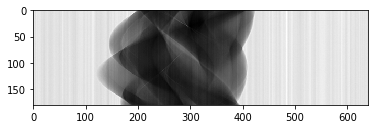

In [8]:
plt.imshow(proj[:, 0, :], cmap='Greys_r')
plt.show()

If the angular information is not avaialable from the raw data you need to set the data collection angles. In this case theta is set as equally spaced between 0-180 degrees.

Perform the flat-field correction of raw data: $$ \frac{proj - dark} {flat - dark} $$

Tomopy provides various methods to [find rotation center](http://tomopy.readthedocs.io/en/latest/api/tomopy.recon.rotation.html).

Calculate $$ -log(proj) $$
Reconstruction using Gridrec algorithm.Tomopy provides various [reconstruction](http://tomopy.readthedocs.io/en/latest/api/tomopy.recon.algorithm.html) methods including the one part of the [ASTRA toolbox](https://sourceforge.net/p/astra-toolbox/wiki/Home/).
Mask each reconstructed slice with a circle.

In [9]:
%%time
proj, flat, dark, theta = dxchange.read_aps_32id(fname, sino=(start, end))
theta = tomopy.angles(proj.shape[0])
proj = tomopy.normalize(proj, flat, dark)
rot_center = tomopy.find_center(proj, theta, init=290, ind=0, tol=0.5)
proj = tomopy.minus_log(proj)
recon = tomopy.recon(proj, theta, center=rot_center, algorithm='gridrec')
recon = tomopy.circ_mask(recon, axis=0, ratio=0.95)

CPU times: user 1.25 s, sys: 483 ms, total: 1.73 s
Wall time: 951 ms


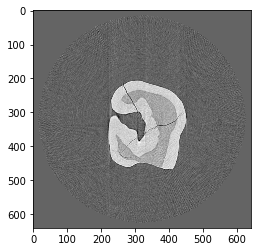

In [10]:
plt.imshow(recon[0, :,:], cmap='Greys_r')
plt.show()

# Test Performance of Different Reconstruction Techniques

Test different methods supported:

http://tomopy.readthedocs.io/en/latest/api/tomopy.recon.algorithm.html?highlight=tomopy.recon

‘art’
Algebraic reconstruction technique [C2].

‘bart’
Block algebraic reconstruction technique.

‘fbp’
Filtered back-projection algorithm.

‘gridrec’
Fourier grid reconstruction algorithm [C5], [C19].

‘mlem’
Maximum-likelihood expectation maximization algorithm [C3].

‘osem’
Ordered-subset expectation maximization algorithm [C14].

‘ospml_hybrid’
Ordered-subset penalized maximum likelihood algorithm with weighted linear and quadratic penalties.

‘ospml_quad’
Ordered-subset penalized maximum likelihood algorithm with quadratic penalties.

‘pml_hybrid’
Penalized maximum likelihood algorithm with weighted linear and quadratic penalties [C15].

‘pml_quad’
Penalized maximum likelihood algorithm with quadratic penalty.

‘sirt’ Simultaneous algebraic reconstruction technique.

In [65]:
recon_methods = ['gridrec', 'art', 'bart', 'mlem', 'osem', 'ospml_hybrid', 'pml_hybrid' ,'sirt']
#recon_methods = ['gridrec']
results = pd.DataFrame(columns=["ReconstructionType", "Runtime"])
for i in recon_methods:
    print "Running: %s"%i
    start = time.time()
    recon = tomopy.recon(proj, theta, center=rot_center, algorithm=i)
    end = time.time()
    res = "%s,%.5f"%(i, end-start)
    results=results.append({"ReconstructionType": i, "Runtime": end-start}, ignore_index=True)


Running: gridrec
Running: art
Running: bart
Running: mlem
Running: osem
Running: ospml_hybrid
Running: pml_hybrid
Running: sirt


In [66]:
results

,ReconstructionType,Runtime
0,gridrec,0.046041
1,art,3.139585
2,bart,1.682422
3,mlem,1.683252
4,osem,1.629995
5,ospml_hybrid,1.681333
6,pml_hybrid,1.745349
7,sirt,1.629844


In [64]:
plt = results.plot(kind="barh", x="ReconstructionType", y="Runtime", use_index=False)
plt.set_xticks(["a,", "b", "c", "d", "e"])

AttributeError: 'NoneType' object has no attribute 'seq'

AttributeError: 'NoneType' object has no attribute 'seq'